# [Character-based_RNN_generator](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)

---


(参考：  [1]()
  [2]())

```
../../
└── My Drive
    ├── Colab Notebooks
    ├── private
    └── remote-colab
        ├── Colab Notebooks
        ├── datasets
        │   ├── kaggle
        │   │   └── titanic
        │   └── ml100knock
        │       ├── 10_Questionnaire_analysis
        │       ├── 1_web_order
        │       ├── 2_Retail_data
        │       ├── 3_Customer_information
        │       ├── 4_Customer_behavior
        │       ├── 5_Customer_withdrawal
        │       ├── 6_Logistics_route
        │       ├── 7_Logistics_network
        │       ├── 8_Numerical_simulation
        │       └── 9_Potential_customer
        │           ├── img
        │           └── mov
        ├── imgs
        └── setting
            └── __pycache__
```



In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
cd /content/drive/My Drive/remote-colab/Colab\ Notebooks/pytorch_practice

/content/drive/My Drive/remote-colab/Colab Notebooks/pytorch_practice



ここまでおまじない

---
# モジュールのインポート、学習データのファイル名の表示
---
 - `io` : ファイル読み込み
 - `grob` :ディレクトリ・ファイル名の抽出
 - `os`　：環境変数へのパス追加など
 
 - `__future__` :python2系→3系への移行用モジュール。多分なくても動く。
   - `unicode_literals`
   - `print_function`
   - `division`

 - `unicodedata` : 文字列や数値を指定する形式に変換できる。便利そう。
 - `string` : 各種文字列をピックアップできる。正規化や文字列検索に便利そう。


In [52]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Dutch', 'Chinese', 'Vietnamese', 'Spanish', 'Czech', 'Greek', 'Polish', 'Irish', 'Portuguese', 'Arabic', 'Scottish', 'English', 'French', 'German', 'Russian', 'Italian', 'Japanese', 'Korean']
O'Neal


---
# RNNの定義
---
## Character-based RNN Predictorとの差分を記載。
 
 - `i : input layer`
 
> 語彙サイズ（`character-based`の英語なら26+α、日本語ならカナで50+α、漢字を含めたりすると膨大な数。）
を基準とするが、前ステップの`hidden state`を用いるため、`dim(i)`にはさらに`hidden layer`のユニット数が加えられたものとなる。今回は語彙サイズ(=`n_letters`)

上記に加えて、`n_categories`が追加される。これは、言語生成の際に、`n_categories`を`condition`とした条件付き生成を行うためである。

`n_categories`のみを入力とした場合、単純に学習データの全人名をもとに言語モデルが構築され、国名カテゴリが介在する余地はない。`n_categories`を表す`1_of_k`ベクトルを入力として追加することで、国名毎の人名生成の出し分けが仕組み上可能となる。



 - h : `hidden layer`
 
> ユニットサイズは`input layer`のサイズや搭載するモデルのサイズ、解きたい問題や処理速度を基準に設定するのが一般的。明確な基準はない。`Word2Vec`は、`dim(n)=100`程度と低次元にまで圧縮する。なお、開始時点の`hidden state`は「0」を基準にする。`seq2seq`であれば`encoding`された`tensor`を用いる。

変化なし。

 - `o : output layer`
 
> カテゴリ推定であればカテゴリ数、言語生成であればボキャブラリサイズ。`softmax`関数を用いて予測分布の総和が「１」となるような分布が形成される。マルチカテゴリ推定では`sigmoid`関数が用いられることが多く
総和は「１」とならず、`dim(o)*1`までの範囲となる。

上記に加えて、`hidden_size`が`concat`される。正確には、`outpot_layer`が２つ存在し、1つ目の`outpot_layer`が上記の次元となる。最終的には`output_layer`のサイズは（前回はカテゴリ数であったが）、`vocab_size`となる。これは、言語生成において予測すべきは次の単語のインデックスであり、仮に`hidden_size`を割り当てた`index`を予測した場合に、`RNN`は該当する存在しないアルファベットを出力する必要があるため、正常動作の妨げとなることから当然であるといえる。

ネットワーク構成が変化し、`hidden_state`が複数回出現した要因としては、（おそらく）入力データの形式が変化しており、学習難易度が高くなるため、`hidden_state`の伝搬が相対的に薄まり、ステップごとの伝搬を有効に活用できくなるという問題への対策だと考えられる。


 - `i2h` : `hidden state`への変換。大抵は線形変換。
 - `i2o` : `output state`への変換。大抵は線形変換。
 
 厳密に表す場合、上記は`i_2_o1`となる。
 - `o2o` : `output state`の再変換。大抵は線形変換。
 
 厳密に表す場合、上記は`o1_2_o2`となる。

 - `dropout` : いくつかのユニットの出力をリセットさせる。

 `NN`におけるパラメータ総数$N$はレイヤ$U$、各レイヤにおけるユニット$U$を用いて下記で表される膨大な数である。
 

 $$L={l_1,...,l_i,...,l_N}$$
 
 
 $$U={u_1,...u_i,...u_N}$$
 
 
 $$N=\sum_{i=1}^{N-1}{u_i*u_{i+1}}$$

 

  パラメータ数が多いほど過学習が起こりやすいことが経験的に知られており、 これに対して`dropout`は確率$p$に従ってレイヤ間を断線させモデルの汎化性能を向上する手法である。本生成についていえば、学習データの数がモデルの柔軟性に比べて少数であり、過学習を避けるために導入されているとい言える。

 - `softmax` : 

In [0]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

---
# 学習データの辞書作成
---

 - `data/`以下のファイルを言語ごとに読み込み、辞書として定義（=`category_lines`）
 - カテゴリやその数なども同様に定義（=`all_categories`, `n_categories`）
辞書の`key`は「言語」、`Value`は「人名」



In [0]:

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [0]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


---

# 文字列から`Tensor`への変換
---

 - 文字列→`Tensor`へ変換するプロセス、`NN`に入力するパラメータの準備を実施
  - 文字をインデックスへ変換（=`letterToIndex`)し、`torch`を用いて該当インデックスを`[1]`として
  
    `1_of_k`表記（=テンソル）へ変換（=`letterToTensor`）。文字列をそのまま`NN`で扱うことはできないため、
    
    何かしらの`ID`への変換を行う。
  - 高次元パラメータであり、情報空間における無駄は多い。
  - この`Tensor`を線形変換及び`LeLU`、`sigmoid`、`softmax`,`tanh`関数などを用いて適切な意味表現に変換し、`input`~`output`の写像を定義する。
 - `1_of_k`表記はその代表的なものである。タスクで用いる`dim(k)=`語彙サイズ
  - また上記を文字列へ拡張し、2次元`Tensor`を作成する（=`lineToTensor`）。
 - この`Tensor`は、学習の際はステップごとにスライスされ、1次元`Tensor`として扱われる。


In [0]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


---
# RNNの定義
---

 - `NN`のネットワークグラフを定義し、今回のタスクにセット。(=`RNN(n_letters, n_hidden, n_categories`))
  - `def __init__()`でネットワークグラフを定義。
  - `def forward()`で前向き伝搬。
  - `def initHidden()`で隠れ層（=`hidden layer`）の初期値を定義。

 - `i : input layer`
 
 語彙サイズ（`character-based`の英語なら26+α、日本語ならカナで50+α、漢字を含めたりすると膨大な数。）
 
 を基準とするが、前ステップの`hidden state`を用いるため、`dim(i)`にはさらに`hidden layer`の
 
 ユニット数が加えられたものとなる。今回は語彙サイズ(=`n_letters`)

 - h : `hidden layer`
 
 ユニットサイズは`input layer`のサイズや搭載するモデルのサイズ、解きたい問題や
 
 処理速度を基準に設定するのが一般的。明確な基準はない。`Word2Vec`は、`dim(n)=100`程度と低次元にまで圧縮する。
 
 なお、開始時点の`hidden state`は「0」を基準にする。`seq2seq`であれば`encoding`された`tensor`を用いる。

 - `o : output layer`
 
 カテゴリ推定であればカテゴリ数、言語生成であればボキャブラリサイズ。`softmax`関数を用いて予測分布の総和が
 
 「１」となるような分布が形成される。マルチカテゴリ推定では`sigmoid`関数が用いられることが多く
 
 総和は「１」とならず、`dim(o)*1`までの範囲となる。

 - `i2h` : `hidden state`への変換。大抵は線形変換。
 - `h2o` : `output state`への変換。大抵は線形変換。



In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

---
# 各学習ステップでのスライスの定義
---


 - `'Albert'`であれば、`'A'`が`input`, `'l'`が`output`の教師データ。`'A'`から`'l'`を予測する過程に得られる`hidden state`を
 
 次ステップの`hidden state`(=`next_hidden`)として、学習過程を伝搬する。
 
 - この`hidden_state`は、直観的には過去すべての入力系列の情報を含んでいるが、直前の学習ステップの影響を強く受け、
 
 序盤の`hidden state`スコアは軽視される。
 
 - これは、各ステップにおける`hidden state`ごとに線形変換の繰り返される回数が異なるためであり、数十ステップを超えた
 
 系列の振る舞いを適切に追従するには至らない。
 
 - この問題の解決に（`LSTM：Long Short Term Meory`）が一般的に利用される。
 `LSTM`では、`hidden state`を別のメモリとして定義し、`input gate`, `forgot gate`, output gateの3つの加減算および要素積を用いて勾配消失を低減する。


In [0]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9821, -2.8956, -2.9123, -2.9481, -3.0328, -2.9957, -2.9235, -2.9310,
         -2.8368, -2.9061, -2.8465, -2.8214, -2.8099, -2.8231, -2.8266, -2.8653,
         -2.8728, -2.8341]], grad_fn=<LogSoftmaxBackward>)


___
# インデックスの返却
---


 - output stateの形成する確率分布から、最も正規確率の高いカテゴリ1つを選択し、そのインデックスを返却する。



In [0]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 12)


---
# 学習データの取得
---

 - 事前に定義した辞書`{'Language':[Name1, Name2, ...]}`から`random`モジュールを用いてランダムなExampleを1例だけ取得する。その後、`Tensor`とする。
 - なおこの`Tensor`について、`dim(Example)=(len(Example),len(all_letters))`となる`1_of_k`の2次元配列となる（はず）。
このあと`Example`のTensorをスライスして、逐次的に処理する。


In [0]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Shahmatov
category = Vietnamese / line = Lam
category = Russian / line = Ryjenkov
category = Japanese / line = Kogo
category = Chinese / line = Niu
category = Korean / line = Sun
category = Italian / line = Alcheri
category = Portuguese / line = Santiago
category = Arabic / line = Boutros
category = Portuguese / line = Gaspar


---
# 損失関数の定義
---

 - 損失関数は、負の対数確率を基準とする。（`Negative Log Likelihood`）
 
 直観的には、予測された確率とゴールドシーケンスの差分を解消すべきだが、少数点以下の極めて小さな誤差は計算機におけるアンダーフローの影響を受ける可能性がある。
 - 上記を対数化することで、確率は0に近いほど負に、無限大に発散する単調増加関数に置き換えられる。この関数を最小化する、あるいは符号を反転して最大化するように誤差を評価する。
 - この手続きは、Negative Log Likelihoodが単調増加関数であるため成り立つ。


In [0]:
criterion = nn.NLLLoss()

---
モデルの学習
---

 - `category_tensor`, `line_tensor`をもとに学習を行う。
　上記の入力は、それぞれ`1*len(all_category)`の`1_of_k`の1次元`Tensor`と
　`len(Example)*len(all_letters)`の`1_of_k`の2次元`Tensor`からなる。

 - 最初に`hidden state`を`zero_Tensor`として初期化し、`RNN`の勾配もまた`0`として初期化する。
 この理由としては、過去の学習で得られた勾配が評価の際にノイズとなり、評価結果の再現性を得られなくなるといった事象を防ぐことが挙げられる。

 - 人名を表す`Tensor(=line_tensor)`を文字レベルでスライスし、各ステップにて次の文字を予測し、その損失を`NLL`により評価する。（誤差を計算する。）
この誤差を逆伝搬し、各レイヤの重みに関する損失関数の勾配を計算する。

 - `Learning rate（:Lr）`は、勾配に対する重みの更新幅に影響する。
本コードでは定数としているが、`epoch`ごとに`Lr`を変化させるといったことも可能である。これにより、学習速度を高速化することができる。

 - これは`Pytorch`が、`Define by run`という方式に基づいて設計されているからであり、日本製の`Chainer`やカーネギーメロン大の`DYNET`なども同様の方式である。
 
 - 反面、`TensorFlow`や`Keras`などは`Define And Run`方式という、あらかじめネットワークおよび学習方法を定義する方式であり、複雑なネットワークを構築しづらい。




In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

---
# `Predictor`の」構築

 - 人名における国名の`Predictor`を構築する。
構築における学習回数（`=n_iters`）は`100000`回である。
また、学習過程を`5000iter`毎に表示する。

 - `iteration`の際には、サンプルをランダムに選択して学習を行う。ランダムにサンプルする場合、各学習データのサンプリング回数や順番が同一とならない事を意味し、これは、例えば`Lr`や`Layer`を変更した際の学習効果を測定する事を考えると好ましくない。
 - 対策としては、例えばあらかじめ国名：人名のペアを辞書ではなくリストとして構築し、逐次的にスライスすることで順番や学習回数を固定化することができる。またこれはバッチ処理/ミニバッチ処理を行う際にも、手続きがシンプルである点において好ましい。
 - `iteration`毎に計算される損失（`=loss`）を`summation`し,`plot_every`事に`loss`の平均をとり、その後`loss`をリセットする。


In [0]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.6025 Wood / Scottish ✓
10000 10% (0m 13s) 1.9043 Dikarev / Russian ✓
15000 15% (0m 19s) 0.4622 Aihara / Japanese ✓
20000 20% (0m 26s) 0.8527 Altimari / Italian ✓
25000 25% (0m 32s) 2.0919 Beltz / Spanish ✗ (German)
30000 30% (0m 39s) 2.0952 William / Scottish ✗ (Irish)
35000 35% (0m 45s) 2.1211 Walker / Dutch ✗ (Scottish)
40000 40% (0m 52s) 1.0564 Paredes / Portuguese ✓
45000 45% (0m 59s) 0.5843 Akechi / Japanese ✓
50000 50% (1m 6s) 0.1172 Nguyen / Vietnamese ✓
55000 55% (1m 13s) 0.5714 Seo / Korean ✓
60000 60% (1m 19s) 0.5831 Hitrov / Russian ✓
65000 65% (1m 26s) 1.0919 Ton / Chinese ✗ (Vietnamese)
70000 70% (1m 32s) 0.3457 Hyun  / Korean ✓
75000 75% (1m 39s) 0.0937 Mikolajczak / Polish ✓
80000 80% (1m 45s) 1.5033 Crowe / English ✓
85000 85% (1m 51s) 1.4123 Dowell / Scottish ✗ (English)
90000 90% (1m 58s) 0.2911 Asfour / Arabic ✓
95000 95% (2m 4s) 1.4886 Bazzi / Italian ✗ (Arabic)
100000 100% (2m 11s) 0.9192 Villanueva / Spanish ✓


---
# 損失の可視化
---

損失（`loss`）の推移を`plot`すると、学習が進むにつれて減少していることがわかる。


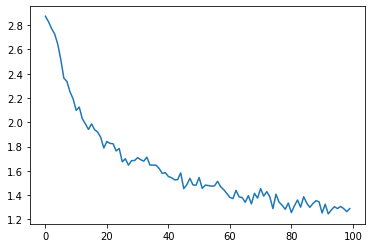

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

---
評価
---

 - `evaluate`では、人名（単文字列）の`Tensor`を受け取り、文字（`Character`）毎の`Tensor`を用いて、`rnn()`で予測分布と`hidden_state`を返す。これを`n_confusion`の数だけ繰り返す。
 - この処理では`backwead()`処理を行っておらず、重みの更新は行っていない。
 - また、評価には学習データが用いられており、これは下記を意味する
  - モデル構築を用いた学習データをもとに予測を行っているため、予測精度が良いのは当然のこととなる。
 - 実際は、学習データ、評価データ、テストデータに分割して、学習データと評価データの`loss`の差分が少なくなるようにチューニングを行い、最終的な評価はテストデータを用いるべきである。
 - その後、各カテゴリにて予測された回数を正規化する。
 - その後、混合マトリクスにて評価結果を表示する。

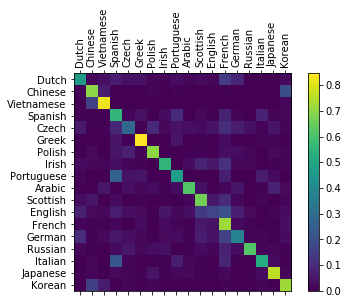

In [0]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

---
# 可視化
---

 - `predict()`関数を用いて、名前から国名のTOP3を予測する。対数尤度での出力となっており、確率に変換して出力したほうが親切。


In [0]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.67) Russian
(-0.91) Czech
(-3.67) Polish

> Jackson
(-0.81) English
(-1.60) Scottish
(-2.03) Russian

> Satoshi
(-0.93) Japanese
(-1.61) Arabic
(-2.20) Polish
